# **Домашнее задание #5. Раскраски для взрослых**

Сегодня наконец-то займемся настоящими делами. Будем повторять подвиг создателей [pix2pix](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix), только на своем датасете. Данные бери [тут](https://drive.google.com/file/d/1Uh7eFfQy3iJU8voK2CmJ-jqQEN4TtSS8/view?usp=sharing). 

За основу работы будем брать оригинальный репозиторий (там надо будет покопаться и взять нужные части, но **не копировать всё тупо, умоляю**), а ещё нужно хорошо разобраться в [статье](https://arxiv.org/pdf/1611.07004.pdf). 

## **Часть 1**. Смотрим на данные (2 балла)

**Стандартный алгоритм**:

1. Закинь архив с данными на `gdrive`, примонтируй диск,  
2. Используй `ImageFolder` для подгрузки данных (посмотри доки насчет организации папки) в `Dataset`, `transform` пока используй аналогично тому, что был в семинаре (1 балл)
3. Отрисуй несколько семплов из трейна и теста (тут надо не забыть разнормализацию, а то атата) (1 балл). 

In [ ]:
import os
import random
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from skimage.feature import canny
from skimage.morphology import binary_dilation

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/pokemon.zip" -d "pokemon"

In [ ]:
image_size = 256
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
trainset = datasets.ImageFolder(root='pokemon/pokemon/train/',  transform=transform)
testset = datasets.ImageFolder(root='pokemon/pokemon/test/',  transform=transform)

In [ ]:
batch_size = 1

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/2

def unnormalize(img, mean=torch.tensor([0.5, 0.5, 0.5]), std=torch.tensor([0.5, 0.5, 0.5])):
  unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
  img_unn = unnormalize(img)
  return img_unn

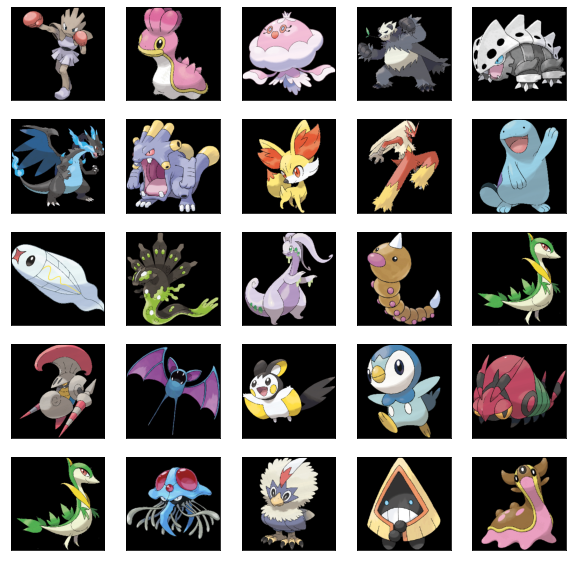

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  random_image_ind = np.random.randint(0, len(trainset))
  img, _ = trainset[random_image_ind]
  img = unnormalize(img).permute(1, 2, 0)
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img)
plt.show()

## **Часть 2.** Готовим данные (6 баллов)

Итак, что же мы хотим? Мы хотим научить GAN раскрашивать покемона по его границам, а значит принцип такой:

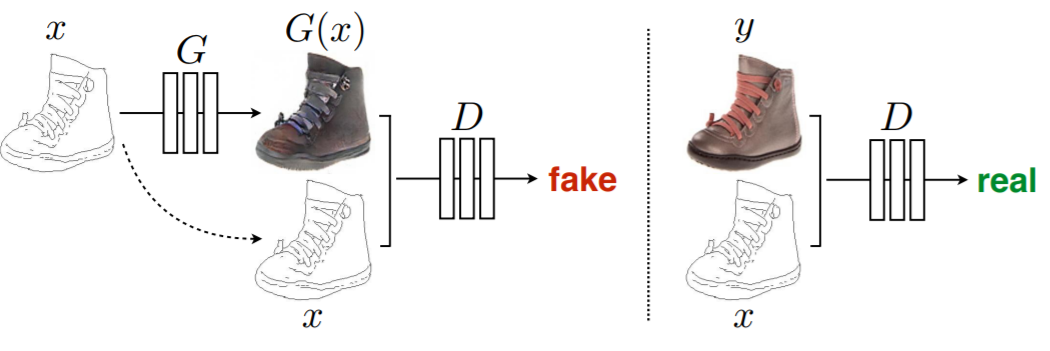

Для обучения GANа для такой задачи нам понадобится парный датасет - для каждой оригинальной картинки нужна карта границ. 



**1.** Напиши функцию ```get_boarders(img) ```, которая будет для изображения получать границы (3 балла). Сделай визуализацию великолепной работы твоей функции на 3-4 примерах. 

**NB**. Какие тут варианты сразу приходят на ум: отделить черные пиксели просто по порогу на цвет, остальные перевести в белые. Если тебя смущают терные элементы на покемонах - можно использовать фильтры для выделения границ, например [Canny](https://scikit-image.org/docs/dev/api/skimage.feature.html#canny). Если границы получаются слишком тонкими и рвутся - можно по бинарной картинке пройтись морфологией - использовать [дилатацию](https://scikit-image.org/docs/dev/api/skimage.morphology.html#binary-dilation), например. 

**2.** Заводим `class PairedDataset`, который будет выдавать парочки - $A$ (границы) и $B$ (покемона), смотрим что с ним всё окей (3 балла).

**NB**. Какие тут очевидные стратегии:
- либо с помощью ```get_boarders(img) ``` предобработать каждую картинку и положить рядом с оригинальными (например с теми же именами но в соседнюю папку, а в Датасете хранить разные пути к границам и оригиналу (мы там делали в задании с дететкором фактически)
- либо для читаемой картинки в своем `PairedDataset` классе получать карту границ и на выход из датасета подавать картинку и её только что посчитанные границы.   

In [ ]:
def get_boarders(img, sigma=1, low_threshold=0.2, high_threshold=0.3):
  transform_to_pil_image = transforms.Compose([transforms.ToPILImage()])
  transform_to_tensor = transforms.Compose([transforms.ToTensor()])
  img = transform_to_pil_image(img).convert('RGB')
  img = transform_to_tensor(img)[0].numpy()
  canny_img = canny(img, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
  return canny_img

Подберем значение параметров canny для более качественных границ

In [ ]:
def choose_parameters_for_canny(values, name):
  for i in range(5):
    num_of_plots = len(values) + 1

    plt.figure(figsize=(20, 20))
    plt.subplot(1, num_of_plots, 1)

    img, _ = trainset[i]
    img = unnormalize(img)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img.permute(1, 2, 0))

    i = 1
    for value in values:
      if name == 'sigma':
        boarders = get_boarders(img, sigma=value)
      elif name == 'low_threshold':
        boarders = get_boarders(img, low_threshold=value)
      elif name == 'high_threshold':
        boarders = get_boarders(img, high_threshold=value)
      else:
        print('Incorrect name of parameter')
        
      plt.subplot(1, num_of_plots, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(boarders, cmap=plt.cm.binary)
      plt.title(f"Param = {round(value, 1)}")

      i += 1
    plt.show()

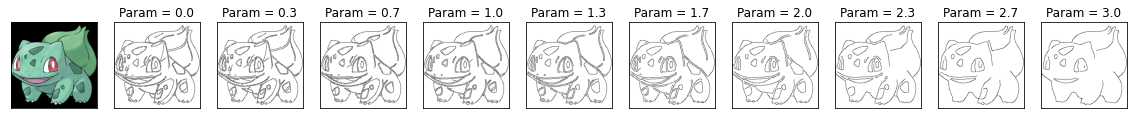

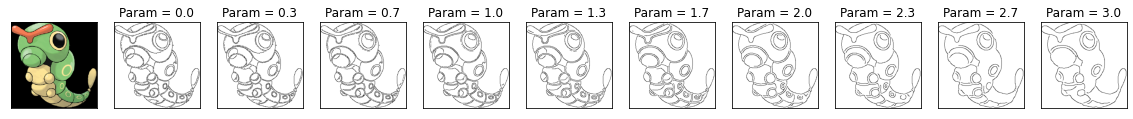

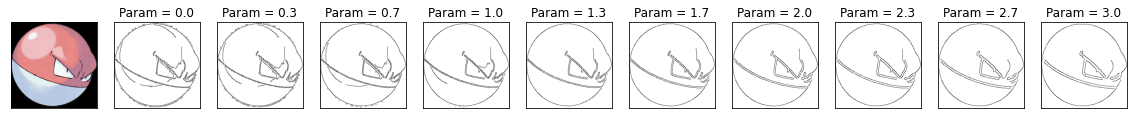

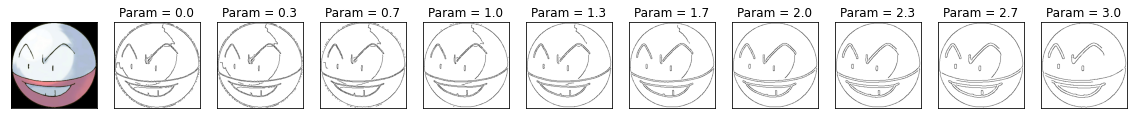

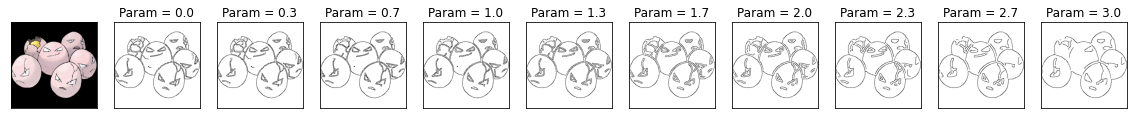

In [ ]:
# choose sigma

values = np.linspace(0, 3, 10)
choose_parameters_for_canny(values, 'sigma')

Сложно однозначно сказать, но вроде sigma=1 лучше всего.

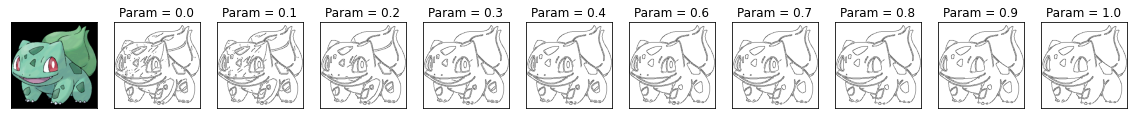

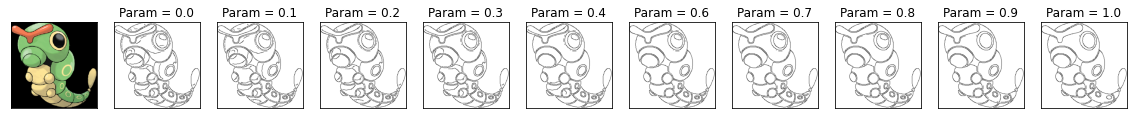

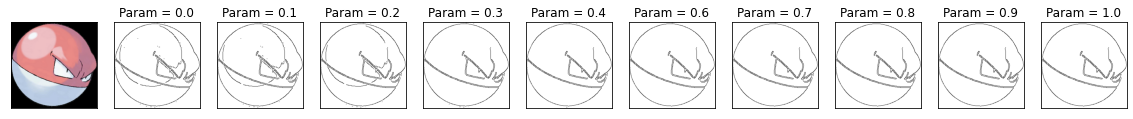

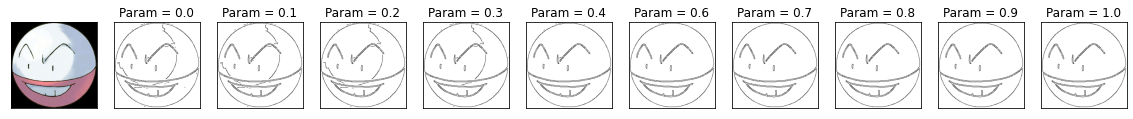

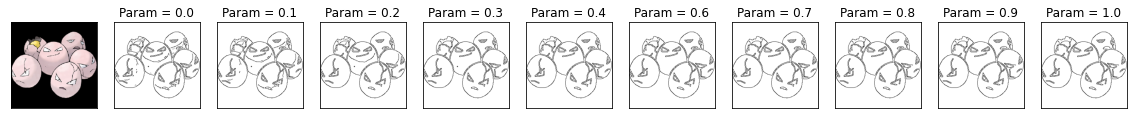

In [ ]:
# choose high threshold

values = np.linspace(0, 1, 10)
choose_parameters_for_canny(values, 'high_threshold')

Кажется, что high_threshold = 0.3 - оптимальное значение.

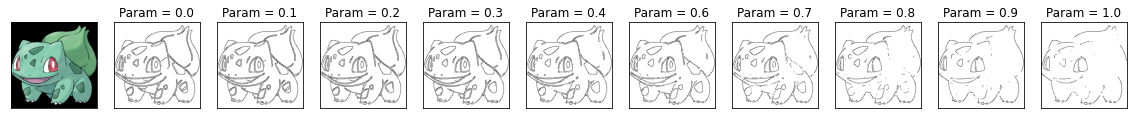

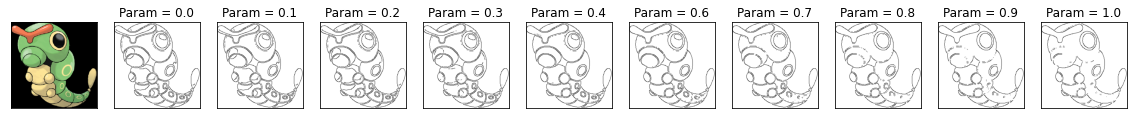

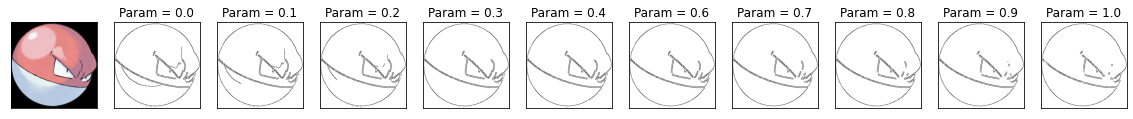

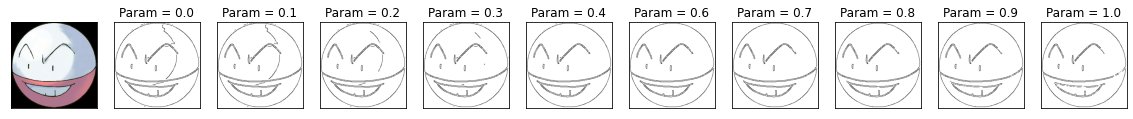

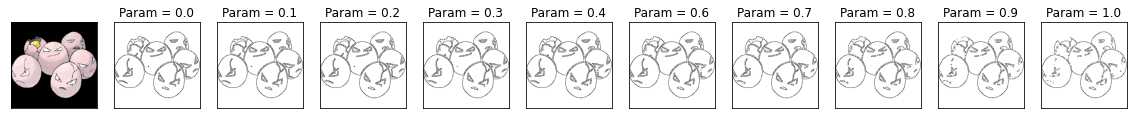

In [ ]:
# choose low threshold

values = np.linspace(0, 1, 10)
choose_parameters_for_canny(values, 'low_threshold')

Кажется, что high_threshold = 0.2 - оптимальное значение.

 Дилатация жирнит границы, что помешает при раскраске, так ее использовать не будем.

Посмротрим, как получилось вычислять границы

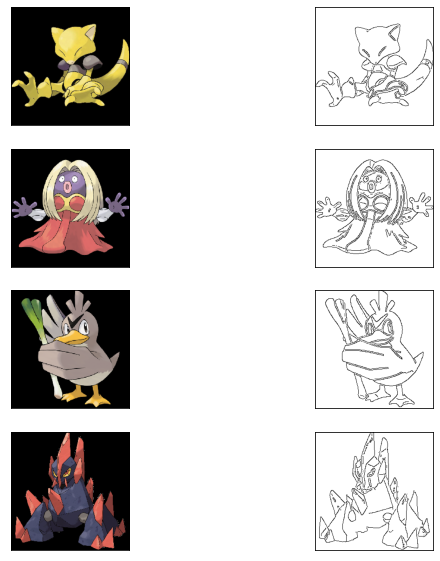

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(0, 8, 2):
  random_image_ind = np.random.randint(0, len(trainset))
  img, _ = trainset[random_image_ind]
  img = unnormalize(img)
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img.permute(1, 2, 0))

  boarders = get_boarders(img)
  plt.subplot(4,2,i+2)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(boarders, cmap=plt.cm.binary)
plt.show()


Очень неплохо:)

In [ ]:
# PairedDataset class

class PairedDataset(torch.utils.data.Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  
  def __getitem__(self, idx):
    img, _ = self.dataset[idx]
    boarders = torch.from_numpy(get_boarders(img)).float()

    return boarders, img
  
  def __len__(self):
    return len(self.dataset)

In [ ]:
paired_trainset = PairedDataset(trainset)
paired_testset = PairedDataset(testset)

In [ ]:
def collate(batch):
    boarders = []
    imgs = []
    for item in batch:
        boarder, img = item
        boarder = boarder[None, :, :]
        boarders.append(boarder)
        imgs.append(img)

    boarders = torch.stack(boarders, dim=0)
    imgs = torch.stack(imgs, dim=0)
    return boarders, imgs

Проверим, что PairedDataset заведен корректно

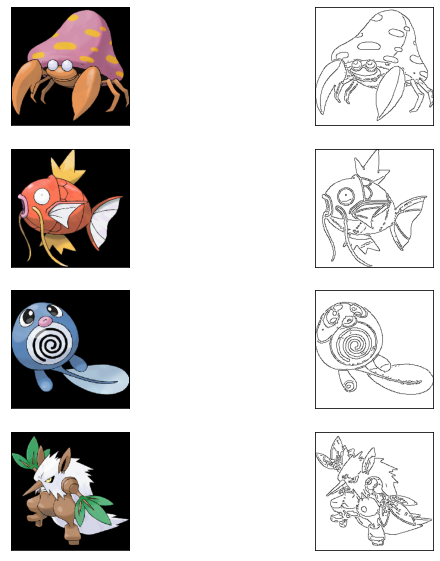

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(0, 8, 2):
  random_image_ind = np.random.randint(0, len(trainset))
  boarders, img = paired_trainset[random_image_ind]
  img = unnormalize(img)
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img.permute(1, 2, 0))
  plt.subplot(4,2,i+2)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(boarders, cmap=plt.cm.binary)
plt.show()

## **Часть 3.** Учим модель (12 баллов)

Итак, данные у нас есть. Пора подумать об архитектуре. 

**1.** Заведи классы ```Generator(nn.Module)```, ```Discriminator(nn.Module)``` (как мы делали на семинаре) для сборки таких архитектур генератора и дискриминатора, которые тебе нравятся. Тут надо подумать какой будет размер входа и выхода обеих частей (2 балла за каждую модельку).

**NB**. По поводу генератора - авторы топят за `U-net`, из моей практики лучше всего работала `ResNet9blocks`. Ты можешь выбрать [какую хочешь](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py), а может даже попробовать несколько и выбрать в итоге одну. 

**2.** Посмотри модель [тут](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/pix2pix_model.py). На самом деле здесь уже написано обучение, разберись, что там происходит и из чего состоит loss (помни, что в этой задаче не только мнение дискриминатора учитывается, а значит loss из двух частей состоит) и напиши свой итератор по эпохам (можно с функцией `run_epoch`) с трекингом лоссов G, D (мы так делали на семинаре). Также для каждой эпохи сохраняй прогресс генератора на тестовых 20 картинках (будем потом посмотреть на эволюцию). Постарайся добиться визуально наилучших результатов. (6 баллов)

**NB.** Гиперпараметры (lr, optimizer, etc) смотри в коде семинара и в репозитории. Хорошо работают маленькие батчи, стоит попробовать batch=1.

**3.** После обучения сделай визуализацию лоссов и изменений картинок на тестовом сете (анимашку как на семинаре). Напиши резюме что получилось, что нет и как ты любишь DL (2 балла).







Возьмем Generator и Discriminator из репозитория

In [ ]:
# https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


class Generator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(Generator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [ ]:
# https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py

class Discriminator(nn.Module):
    """Defines a 1x1 PatchGAN discriminator (pixelGAN)"""

    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d):
        """Construct a 1x1 PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        """Standard forward."""
        return self.net(input)

In [ ]:
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>

def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net

In [ ]:
class GANLoss(nn.Module):
    """Define different GAN objectives.
    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.
        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image
        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.real_label = torch.tensor(target_real_label)
        self.fake_label = torch.tensor(target_fake_label)
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.
        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.
        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


def cal_gradient_penalty(netD, real_data, fake_data, device, type='mixed', constant=1.0, lambda_gp=10.0):
    """Calculate the gradient penalty loss, used in WGAN-GP paper https://arxiv.org/abs/1704.00028
    Arguments:
        netD (network)              -- discriminator network
        real_data (tensor array)    -- real images
        fake_data (tensor array)    -- generated images from the generator
        device (str)                -- GPU / CPU: from torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        type (str)                  -- if we mix real and fake data or not [real | fake | mixed].
        constant (float)            -- the constant used in formula ( ||gradient||_2 - constant)^2
        lambda_gp (float)           -- weight for this loss
    Returns the gradient penalty loss
    """
    if lambda_gp > 0.0:
        if type == 'real':   # either use real images, fake images, or a linear interpolation of two.
            interpolatesv = real_data
        elif type == 'fake':
            interpolatesv = fake_data
        elif type == 'mixed':
            alpha = torch.rand(real_data.shape[0], 1, device=device)
            alpha = alpha.expand(real_data.shape[0], real_data.nelement() // real_data.shape[0]).contiguous().view(*real_data.shape)
            interpolatesv = alpha * real_data + ((1 - alpha) * fake_data)
        else:
            raise NotImplementedError('{} not implemented'.format(type))
        interpolatesv.requires_grad_(True)
        disc_interpolates = netD(interpolatesv)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolatesv,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)
        gradients = gradients[0].view(real_data.size(0), -1)  # flat the data
        gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - constant) ** 2).mean() * lambda_gp        # added eps
        return gradient_penalty, gradients
    else:
        return 0.0, None

Зададим модель, в которой объединим шаги генератора и дискриминатора.

In [ ]:
class Pix2PixModel(nn.Module):
    def __init__(self, netG, netD, optimizer_G, optimizer_D, scheduler_G, scheduler_D, criterionL1, criterionGAN, lambda_L1=100):
        super(Pix2PixModel, self).__init__()

        self.netG = netG
        self.netD = netD

        self.optimizer_G = optimizer_G
        self.optimizer_D = optimizer_D

        self.scheduler_G = scheduler_G
        self.scheduler_D = scheduler_D

        self.criterionL1 = criterionL1
        self.criterionGAN = criterionGAN

        self.lambda_L1 = lambda_L1

    def set_input(self, input):
        self.real_A = input[0].to(device)
        self.real_B = input[1].to(device)

    def forward(self):
        self.fake_B = self.netG(self.real_A)

    def backward_D(self):
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)
        pred_fake = self.netD(fake_AB.detach()).cpu()
        self.loss_D_fake = self.criterionGAN(pred_fake, False)

        real_AB = torch.cat((self.real_A, self.real_B), 1)
        pred_real = self.netD(real_AB).cpu()
        self.loss_D_real = self.criterionGAN(pred_real, True)

        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)
        pred_fake = self.netD(fake_AB).cpu()
        self.loss_G_GAN = self.criterionGAN(pred_fake, True)

        self.loss_G_L1 = self.criterionL1(self.fake_B, self.real_B) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def set_requires_grad(self, nets, requires_grad=False):
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

    def update_lr(self):
        self.scheduler_G.step()
        self.scheduler_D.step()

    def optimize_parameters(self):
        self.forward() 

        # update D
        self.set_requires_grad(self.netD, True)  
        self.optimizer_D.zero_grad()     
        self.backward_D()                
        self.optimizer_D.step()

        # update G
        self.set_requires_grad(self.netD, False)  
        self.optimizer_G.zero_grad()        
        self.backward_G()                   
        self.optimizer_G.step()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Зададим параметры

In [ ]:
num_epochs = 20
lr = 0.0002
beta1 = 0.5

input_ncg = 1
output_ncg = 3
input_ncd = output_ncg + input_ncg

Зададим модели генератора, дискриминатора и оптимизаторы

In [ ]:
netG = Generator(input_ncg, output_ncg).to(device)
netG = init_net(netG)

netD = Discriminator(input_ncd).to(device)
netD = init_net(netD)

optimizer_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=int(len(paired_trainset)/batch_size + 1)*num_epochs)
scheduler_D = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=int(len(paired_trainset)/batch_size + 1)*num_epochs)

initialize network with normal
initialize network with normal


In [ ]:
criterionGAN = GANLoss('lsgan').to(device)
criterionL1 = torch.nn.L1Loss()

In [ ]:
model = Pix2PixModel(netG, netD, optimizer_G, optimizer_D, scheduler_G, scheduler_D, criterionL1, criterionGAN)

In [ ]:
def run_epochs(trainloader, testloader, num_epochs, device):

    img_list = defaultdict(list)
    G_losses = []
    D_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch: {epoch}')

        for i, data in enumerate(trainloader): 
            model.set_input(data)         
            model.optimize_parameters()  

            G_losses.append(model.loss_G.item())
            D_losses.append(model.loss_D.item())

        model.update_lr()

        # save results
        j = 0
        for data_test in testloader:
            boarders_test = data_test[0]
            boarders_test = boarders_test.to(device)

            if j >= 20:
              break

            with torch.no_grad():
                fake = model.netG(boarders_test).detach().cpu()
            
            img_list[j].append(vutils.make_grid(fake, padding=2, normalize=True))
            j += 1

    return img_list, G_losses, D_losses

In [ ]:
batch_size = 1
paired_trainloader = torch.utils.data.DataLoader(paired_trainset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate)
paired_testloader = torch.utils.data.DataLoader(paired_testset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate)

In [ ]:
img_list, G_losses, D_losses = run_epochs(paired_trainloader, paired_testloader, num_epochs, device)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19


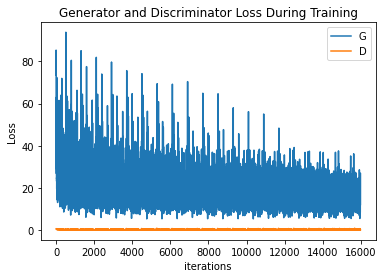

In [ ]:
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Графики лоссов выглядят правдоподобно

Посмотрим на примере одной картинки за эволюцией

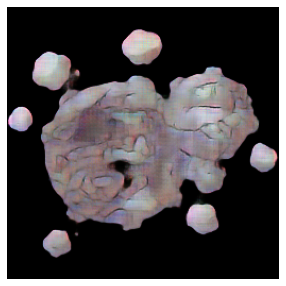

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list[0]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True)

HTML(ani.to_jshtml())

Действительно, от эпохи к эпохе происходит более правдоподобная раскраска.

Посмотрим на пары изображений: (реальное, сгенерированное)

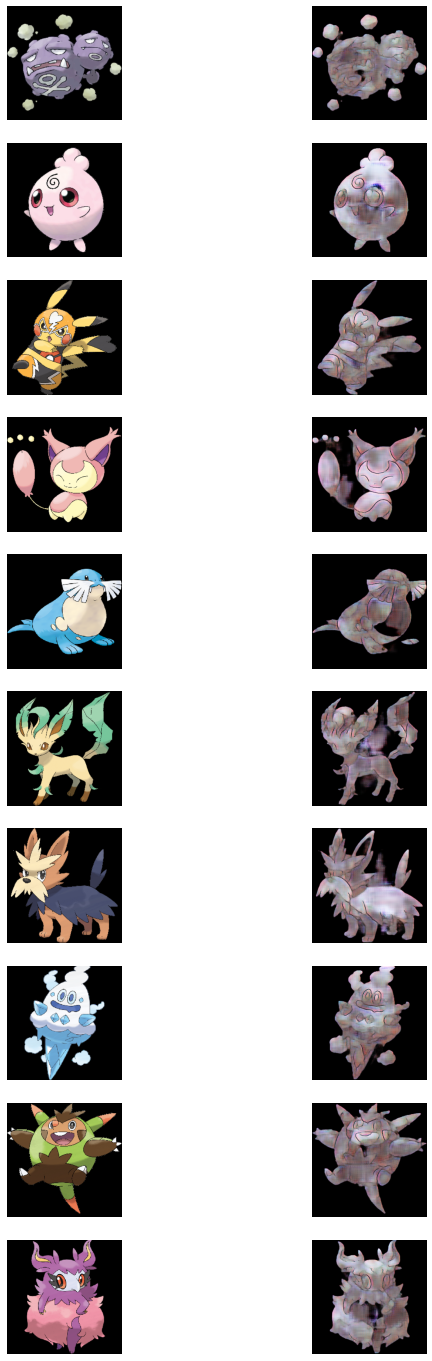

In [ ]:
plt.figure(figsize=(10, 50))
for i in range(0, 20, 2):

  _, real_img = paired_testset[i]
  real_img = unnormalize(real_img)

  plt.subplot(20,2,i+1)
  plt.axis("off")
  # plt.grid(False)
  plt.imshow(np.transpose(vutils.make_grid(real_img.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
  
  plt.subplot(20,2,i+2)
  plt.axis("off")
  # plt.grid(False)
  plt.imshow(np.transpose(img_list[i][-1],(1,2,0)))
plt.show()

Результаты, конечно, далеки от идеальных, но, кажется, что в целом неплохо:) цвет, конечно, не очень похож на исходный, а какой-то грязноватый

**Выводы:**  
- Разобраться и взять нужное даже из готового репозитория не всегда так просто, как кажется на первый взгляд.
- Не очень хорошо получилось возпроизвести цвет при раскраске: видимо, нужно или лучше подбирать гиперпараметры при обучении, или просто побольше эпох
- Это задание, как и курс в целом, были очень интересными и полезными. Спасибо большое:)

Крутота!

**Вот и всё. Какие же мы молодцы ^^**